### References:
* https://github.com/huggingface/transformers/blob/main/src/transformers/models/bert/modeling_bert.py
* https://peterbloem.nl/blog/transformers
* https://arxiv.org/pdf/1810.04805
* https://www.kaggle.com/code/chayan8/sentiment-analysis-using-bert-pytorch
* https://github.com/curiousily/Getting-Things-Done-with-Pytorch/blob/master/3D_photo_inpainting.ipynb -> helpful examples
* https://pytorch.org/hub/huggingface_pytorch-transformers/
* https://medium.com/data-and-beyond/complete-guide-to-building-bert-model-from-sratch-3e6562228891

## 1. Installing new dependencies 

In [ ]:
! pip install transformers datasets
! pip install pytorch-transformers
! pip install pandas seaborn matplotlib numpy
! pip install pytorch_lightning

In [7]:
! pip install pytorch_lightning


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


## 2. Importing Libraries and Load Data

In [2]:
import pandas as pd
import numpy as np

from tqdm.auto import tqdm

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizerFast as BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup

import pytorch_lightning as pl
from torchmetrics.classification import Accuracy, F1Score, AUROC
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping
from pytorch_lightning.loggers import TensorBoardLogger

from sklearn.metrics import classification_report, multilabel_confusion_matrix

import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc

# import libraries
from datasets import load_dataset
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments, AutoTokenizer
from torch.utils.data import TensorDataset
import seaborn as sns
from torch.utils.data import DataLoader, TensorDataset
from torch import nn, optim
import torchvision.transforms as transforms



In [3]:
RANDOM_SEED = 42

sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

pl.seed_everything(RANDOM_SEED)

Seed set to 42


42

In [4]:
# Load the GoEmotions dataset
datasets = load_dataset("go_emotions")

# Print some information about the dataset
print(datasets)
train_df = pd.DataFrame(datasets['train'])
print(train_df.head())

print("Train dataset's shape:",datasets['train'].shape)
print("Validation dataset's shape:",datasets['validation'].shape)
print("Test dataset's shape:",datasets['test'].shape)


DatasetDict({
    train: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 43410
    })
    validation: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5426
    })
    test: Dataset({
        features: ['text', 'labels', 'id'],
        num_rows: 5427
    })
})
                                                text labels       id
0  My favourite food is anything I didn't have to...   [27]  eebbqej
1  Now if he does off himself, everyone will thin...   [27]  ed00q6i
2                     WHY THE FUCK IS BAYLESS ISOING    [2]  eezlygj
3                        To make her feel threatened   [14]  ed7ypvh
4                             Dirty Southern Wankers    [3]  ed0bdzj
Train dataset's shape: (43410, 3)
Validation dataset's shape: (5426, 3)
Test dataset's shape: (5427, 3)


In [5]:
# OPTIONAL
# checking if my GPU is ready to be used for training

gpu_available = torch.cuda.is_available()

if gpu_available:
    print("CUDA is available. GPU detected.")
    # Get the number of GPUs
    num_gpus = torch.cuda.device_count()
    print(f"Number of GPUs: {num_gpus}")
    # Print details about each GPU
    for i in range(num_gpus):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
        gpu_properties = torch.cuda.get_device_properties(i)
        print(f"Properties of GPU {i}: {gpu_properties}")
else:
    print("CUDA is not available. No GPU detected.")

CUDA is available. GPU detected.
Number of GPUs: 1
GPU 0: NVIDIA GeForce RTX 3060 Laptop GPU
Properties of GPU 0: _CudaDeviceProperties(name='NVIDIA GeForce RTX 3060 Laptop GPU', major=8, minor=6, total_memory=6143MB, multi_processor_count=30)


## 3. Preprocessing and training BERT
### Overview steps:
1. Encoding label into hot encoders 
2. Convert dataframe dictionary into dataframe using pandas
3. Import BERT tokenizer to tokenize/encode the text 
5. Created tensor dataset with input ids (originally text), attention masks (from tokenizer/encoder), and label tensors (originally labels) 
6. Importing pre-trained pretrained BERT model to train machine
7. Creatin optimizer and scheduler for training 
8. Setting up and checking GPU for training
9. Train model and evaluate every epoch

### Tokenize and Encode
#### Description:
BERT model  

In [6]:
# importing 
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-uncased',
    do_lower_case=True
)

In [7]:
# implementing data augumentation 
from nltk.corpus import wordnet
import random

def synonym_replacement(text):
    
    words = text.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

In [8]:
df_train = pd.DataFrame(datasets['train'])
df_validation = pd.DataFrame(datasets['validation'])
df_test = pd.DataFrame(datasets['test'])

# print(df_train['labels'])

In [9]:
import re


type_of_emotion = datasets['train'].features['labels'].feature.names

# Function to encode numeric labels to multi-hot vectors 
def encode_labels(labels):
    encoding = [0] * len(type_of_emotion)
    for label in labels:
        encoding[label] = 1
    return encoding

def clean_text(text):
    # Convert text to lowercase
    sentences = re.sub("[.,!?-]", '', text.lower()).split('n')  # filter '.', ',', '?', '!'
    word_list = list(set(" ".join(sentences).split()))
    
    return " ".join(word_list)

# Apply the encoding labels to the DataFrame
df_train['encoded_labels'] = df_train['labels'].apply(encode_labels)
df_validation['encoded_labels'] = df_validation['labels'].apply(encode_labels)
#df_test['encoded_labels'] = df_test['labels'].apply(encode_labels)

# Convert the labels to a list of lists
labels_train_list = df_train['encoded_labels'].tolist()
labels_validation_list = df_validation['encoded_labels'].tolist()
#labels_test_list = df_test['encoded_labels'].tolist()

# Convert to PyTorch tensors
labels_train_tensor = torch.tensor(labels_train_list, dtype=torch.float32)
labels_validation_tensor = torch.tensor(labels_validation_list, dtype=torch.float32)
#labels_test_tensor = torch.tensor(labels_test_list, dtype=torch.float32)

df_train['clean_text'] = df_train['text'].apply(clean_text)
df_validation['clean_text'] = df_validation['text'].apply(clean_text)

# Print the resulting tensor to ensure correctness
print("\nTrain Labels:\n", df_train['clean_text'])
print("\nTrain Labels Tensor:\n", labels_train_tensor)
print("\nValidation Labels Tensor:\n", labels_validation_tensor)
#print("\nTest Labels Tensor:\n", labels_test_tensor)




Train Labels:
 0        ythi favourite to myself food 't i cook did ha...
1        himself will if g ow everyo k screwi i off a s...
2                           why isoi fuck the bayless g is
3                              her to ed make threate feel
4                                    kers souther dirty wa
                               ...                        
43405    hu aspect i’ve game well g what happily the i ...
43406    ythi always to it was fu y refere ce g a but i...
43407    ed [ ly good talki g that bad about what ythi ...
43408                sexy baptism results with a like more
43409                                       joy the ride e
Name: clean_text, Length: 43410, dtype: object

Train Labels Tensor:
 tensor([[0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 0.,  ..., 0., 0., 1.],
        [0., 0., 1.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

Validation

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
C:\Users\jessl\AppData\Local\Temp\ipykernel_43172\2022630639.py:8: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(token_lens)


Text(0.5, 0, 'Token count')

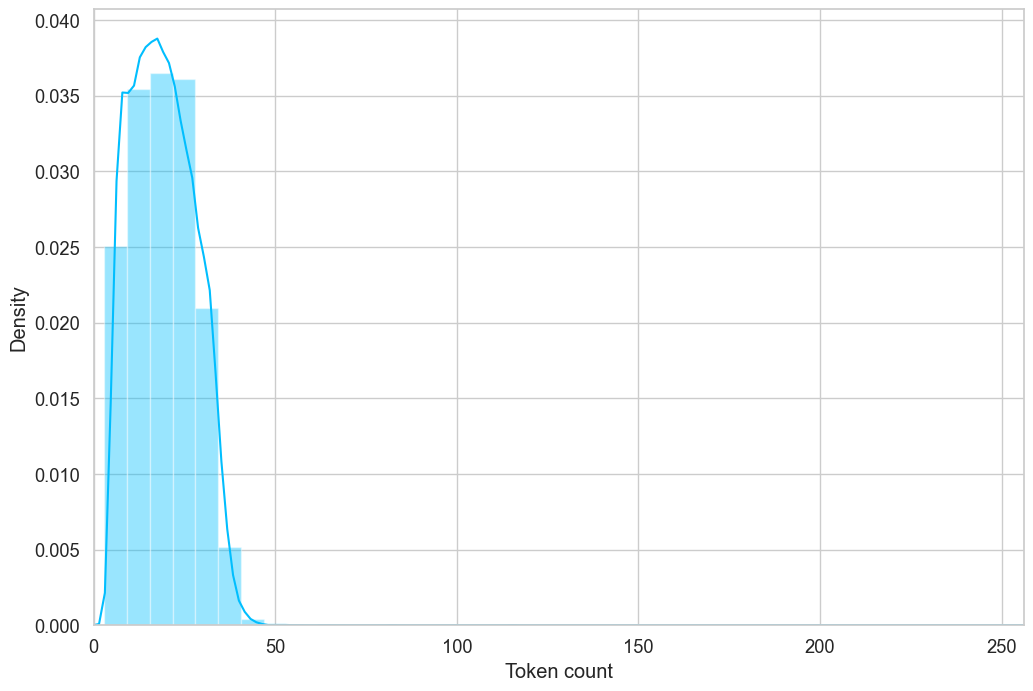

In [10]:
token_lens = []

for txt in df_train.text:
  tokens = tokenizer.encode(txt, max_length=512)
  token_lens.append(len(tokens))
     

sns.distplot(token_lens)
plt.xlim([0, 256])
plt.xlabel('Token count')

In [18]:
import torch
from torch.utils.data import Dataset
from transformers import BertTokenizer

# creating data loaders
# batch size reference https://huggingface.co/docs/transformers/model_doc/bert
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F 

# implementing data augumentation 
from nltk.corpus import wordnet
import random

def synonym_replacement(text):
    
    words = text.split()
    new_words = []
    for word in words:
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            new_words.append(synonym)
        else:
            new_words.append(word)
    return ' '.join(new_words)

def random_insertion(text, n=2):
    words = text.split()
    for _ in range(n):
        word = random.choice(words)
        synonyms = wordnet.synsets(word)
        if synonyms:
            synonym = random.choice(synonyms).lemmas()[0].name()
            insert_index = random.randint(0, len(words) - 1)
            words.insert(insert_index, synonym)
    return ' '.join(words)


class AugmentedDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len
        # Define how you want to apply augmentation
        self.augment = lambda x: random.choice([synonym_replacement, random_insertion, random_deletion])(x)

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = self.texts[idx]
        target = self.targets[idx]
        augmented_text = self.augment(text)

        encoding = self.tokenizer.encode_plus(
            augmented_text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt'
        )

        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)
        }

class EvaluationDataset(Dataset):
    def __init__(self, texts, targets, tokenizer, max_len):
        self.texts = texts
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, item):
        text = str(self.texts[item])
        target = self.targets[item]

        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.float)  # Assuming target is a list or numpy array
        }

targets = len(type_of_emotion)
max_len = 64
train_dataset = EvaluationDataset(df_train.text, df_train['encoded_labels'], tokenizer, max_len)
evaluate_dataset = AugmentedDataset(df_validation.text, df_validation['encoded_labels'], tokenizer, max_len)

print(len(train_dataset))
print(len(evaluate_dataset))

batch_size = 32


dataloader_train = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    num_workers=4, # subprocesses to use for data loading
    batch_size=batch_size,
    pin_memory=True,  #data load will copy tensor to CUDA pinned memory before return (improve GPU stransfer speed)
    prefetch_factor=2 # need google more
)

dataloader_val = DataLoader(
    evaluate_dataset,
    sampler=RandomSampler(evaluate_dataset),
    batch_size=32,
    num_workers=4, 
    pin_memory=True, 
    prefetch_factor=2
)



43410
5426


In [11]:
encoded_data_train = tokenizer.batch_encode_plus(
    df_train.clean_text.values,
    add_special_tokens=True, # adding [CLS] and [SEP]
    return_attention_mask=True, # change input to 1 with actual words and 0 to none
    pad_to_max_length=True, 
    max_length=	64,
    return_token_type_ids=False, # length that is longer than max_length will be trucated
    return_tensors='pt' # returning tensor in pytorch form
)

encoded_data_val = tokenizer.batch_encode_plus(
    df_validation.clean_text.values,
    add_special_tokens=True,
    return_attention_mask=True,
    pad_to_max_length=True,
    max_length=	64,
    return_token_type_ids=False, 
    return_tensors='pt'
)

input_ids_train = encoded_data_train['input_ids']
attention_masks_train = encoded_data_train['attention_mask']

input_ids_val = encoded_data_val['input_ids']
attention_masks_val = encoded_data_val['attention_mask']


c:\Users\jessl\miniconda3\envs\torch_gpu_env\lib\site-packages\transformers\tokenization_utils_base.py:2699: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [74]:
# turning each dataset into tensor dataset to be processed

dataset_train = TensorDataset(input_ids_train, 
                              attention_masks_train,
                              labels_train_tensor)

dataset_val = TensorDataset(input_ids_val, 
                            attention_masks_val,
                           labels_validation_tensor)

dataset_train.tensors

(tensor([[  101,  1061, 15222,  ...,     0,     0,     0],
         [  101,  4756,  2111,  ...,     0,     0,     0],
         [  101, 11163,  2072,  ...,     0,     0,     0],
         ...,
         [  101,  2054,  2020,  ...,     0,     0,     0],
         [  101,  7916,  2066,  ...,     0,     0,     0],
         [  101,  1041,  1996,  ...,     0,     0,     0]]),
 tensor([[1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         ...,
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0],
         [1, 1, 1,  ..., 0, 0, 0]]),
 tensor([[0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 0.,  ..., 0., 0., 1.],
         [0., 0., 1.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]))

In [10]:
import torch
import torch.nn as nn
from transformers import BertModel
import torch.nn.functional as F

class CustomBERTModel(nn.Module):
    def __init__(self, num_labels, hidden_size=512, dropout_rate=0.3):
        super(CustomBERTModel, self).__init__()
        self.bert = BertModel.from_pretrained('bert-base-uncased')
        self.lstm = nn.LSTM(self.bert.config.hidden_size, hidden_size, batch_first=True, bidirectional=True)
        self.layer_norm = nn.LayerNorm(hidden_size * 2)
        self.dropout = nn.Dropout(dropout_rate)
        self.classifier = nn.Sequential(
            nn.Linear(hidden_size * 2, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(hidden_size, num_labels)
        )

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        sequence_output = outputs[0]  # shape: (batch_size, sequence_length, hidden_size)
        
        lstm_output, _ = self.lstm(sequence_output)  # shape: (batch_size, sequence_length, hidden_size*2)
        
        # Use the mean of the LSTM output across the sequence length dimension
        lstm_output_mean = torch.mean(lstm_output, dim=1)  # shape: (batch_size, hidden_size*2)
        
        lstm_output_mean = self.layer_norm(lstm_output_mean)  # shape: (batch_size, hidden_size*2)
        lstm_output_mean = self.dropout(lstm_output_mean)  # shape: (batch_size, hidden_size*2)
        
        logits = self.classifier(lstm_output_mean)  # shape: (batch_size, num_labels)
        probabilities = torch.sigmoid(logits)  # Use sigmoid for multi-label classification
        
        return logits, probabilities

# Example initialization
num_labels = len(type_of_emotion)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = CustomBERTModel(num_labels=num_labels, hidden_size=256).to(device)


In [86]:
'''model = BertForSequenceClassification.from_pretrained(
                                      'bert-base-uncased', 
                                      num_labels = len(type_of_emotion),
                                      output_attentions = False,
                                      output_hidden_states = False
                                     )'''

"model = BertForSequenceClassification.from_pretrained(\n                                      'bert-base-uncased', \n                                      num_labels = len(type_of_emotion),\n                                      output_attentions = False,\n                                      output_hidden_states = False\n                                     )"

In [ ]:
# creating data loaders
# batch size reference https://huggingface.co/docs/transformers/model_doc/bert
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler
import torch.nn.functional as F 

batch_size = 32


dataloader_train = DataLoader(
    train_dataset,
    sampler=RandomSampler(train_dataset),
    num_workers=4, # subprocesses to use for data loading
    batch_size=batch_size,
    pin_memory=True,  #data load will copy tensor to CUDA pinned memory before return (improve GPU stransfer speed)
    prefetch_factor=2 # need google more
)

dataloader_val = DataLoader(
    dataset_val,
    sampler=RandomSampler(dataset_val),
    batch_size=32,
    num_workers=4, 
    pin_memory=True, 
    prefetch_factor=2
)

In [11]:
from transformers import AdamW, get_linear_schedule_with_warmup
from torch.cuda.amp import GradScaler
from torch.optim.lr_scheduler import ReduceLROnPlateau

# optimizer type: 
# Stochastic Gradient Descent (SGD): The basic optimization algorithm that updates parameters based on the gradient of the loss function.
# Adam: A popular variant of SGD that combines adaptive learning rates with momentum.
# AdamW: A variant of Adam that also incorporates weight decay to prevent overfitting.
# Adagrad: Adapts the learning rate for each parameter based on the historical gradient information.
# RMSprop: Root Mean Square Propagation, similar to Adagrad but with an exponentially decaying average of squared gradients.


model = CustomBERTModel(num_labels = len(type_of_emotion))

optimizer = AdamW(
    model.parameters(), # optimizing model
    lr = 1e-5 ,
    eps = 1e-8, # need a further verification
    
)



scaler= GradScaler()


# Scheduler: a learning rate schediler that adjust learning rate during training to improve performance
# type of scheduler:
# StepLR: decreases the learning rate by a factor of the fized number of epochs
# MultiStepLR: similar to StepLR but allows specifying multicle milestones for decreasing learning rate
# ExponentialLR: decays the learning rate expotentially over time
# Reduce LROnPlateau: decrease learning rate when specific metric stops improving -
# CosineAnnealingLR: gradually decreases the learning rate base on cosine
# Linear Warmup: linearly increases the learning rate from zero to the specified value over warmup period -

scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)



c:\Users\jessl\miniconda3\envs\torch_gpu_env\lib\site-packages\transformers\optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
c:\Users\jessl\miniconda3\envs\torch_gpu_env\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


In [12]:
import subprocess
import torch

def get_gpu_usage():
    try:
        result = subprocess.run(['nvidia-smi', '--query-gpu=utilization.gpu', '--format=csv,noheader,nounits'], stdout=subprocess.PIPE)
        gpu_usage = int(result.stdout.decode('utf-8').strip())
        return gpu_usage
    except Exception as e:
        print(f"Error: {e}")
        return None

if __name__ == "__main__":
    gpu_usage = get_gpu_usage()
    if gpu_usage is not None:
        print(f"GPU Usage: {gpu_usage}%")
    else:
        print("Failed to retrieve GPU usage.")

torch.cuda.empty_cache()



GPU Usage: 0%


In [13]:
import random


torch.cuda.empty_cache()

# seeding / setting seeds for various random number to ensure that the result is the same
seed_val = 17
random.seed(seed_val) # sets seed for python's build in libraries
np.random.seed(seed_val) # set seeds for numpy random generator
torch.manual_seed(seed_val) # sets seed for pytorch CPU operations
torch.cuda.manual_seed_all(seed_val) # set seeds for CUDA operation

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.cuda()
print(device)
print(model)

cuda
CustomBERTModel(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elem

In [14]:
from tqdm import tqdm
import numpy as np

def evaluate(dataloader_val):
    model.eval()  # sets model to evaluation mode, no dropout and batch normalization layer
    
    loss_val_total = 0
    predictions, true_vals = [], []  # to store predictions and true labels

    
    for batch in tqdm(dataloader_val):  # iterate over batches of data in validation loader
        
        batch = tuple(b.to(device) for b in batch)  # move batch tensors to the appropriate device
        
        # prepare model inputs tensors 
        input_ids = batch[0]
        attention_mask = batch[1]
        labels = batch[2]
        
        # forward pass
        # performing forward pass without gradient computation
        with torch.no_grad():       
            # passing input tensors to the model and obtain the outputs (loss and logits - raw output scores) 
            logits, probabilities = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(logits, labels)
            
            # calculate raw values 
            loss_val_total += loss.item()

            # processing predictions and true labels            
            logits = logits.detach().cpu().numpy() # detach logits from computational graph -> to CPU -> to numpy array
            label_ids = labels.detach().cpu().numpy() # same concept
            
        
            # Ensure that the shapes are consistent before appending
            if logits.shape[0] == label_ids.shape[0]:
                predictions.append(logits)
                true_vals.append(label_ids)
            else:
                print(f"Shape mismatch: logits {logits.shape}, labels {label_ids.shape}")
    
    loss_val_avg = loss_val_total / len(dataloader_val)
    
    # Debugging: Check the shapes before concatenation
    # print(f"Predictions shapes: {[pred.shape for pred in predictions]}")
    # print(f"True values shapes: {[val.shape for val in true_vals]}")
    
    predictions = np.concatenate(predictions, axis=0)
    true_vals = np.concatenate(true_vals, axis=0)
    
    # Final shape check
    # print(f"Final shape of predictions: {predictions.shape}")
    # print(f"Final shape of true values: {true_vals.shape}")
    
    return loss_val_avg, predictions, true_vals




In [15]:
# setting up performance metrics
import numpy as np
from sklearn.metrics import f1_score

def f1_score_func(preds, labels):
    assert preds.shape[0] == labels.shape[0], f"Shape mismatch: preds {preds.shape}, labels {labels.shape}"
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.argmax(axis=1).flatten()
    
    # Check the shapes after flattening
    # print(f"Shapes after flattening - preds_flat: {preds_flat.shape}, labels_flat: {labels_flat.shape}")
    return f1_score(labels_flat, preds_flat, average = 'weighted')




In [16]:
def accuracy_per_class(preds, labels):
    label_dict_inverse = {v: k for k, v in type_of_emotion.items()}
    
    preds_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    
    for label in np.unique(labels_flat):
        y_preds = preds_flat[labels_flat==label]
        y_true = labels_flat[labels_flat==label]
        print(f'Class: {label_dict_inverse[label]}')
        print(f'Accuracy:{len(y_preds[y_preds==label])}/{len(y_true)}\n')

https://pytorch.org/docs/stable/amp.html

Libraries used for training:
* tqdm: adding progress bars to loops so we can see training progress
* GradScaler: dynamically adjust gradient scale before backward propagation. Ensuring that there is no overflow or underflow by rescalling them to similar as ROC curve (scale 0 to 1)  (https://youtu.be/IkeEadgSy6w)
* Autocast: Automatic Mixed Precision (AMP) feature. Accelerate training by leveraging tensor cores on NVIDA GPUs. used around foward pass and loss calculation

P.S. gradient scaler and autocast is just used when we want to utilize GPU for training
Underflow:  value too small to represent or compute (close to zero)
Overflow: values exceed numerical computations, causing memory leackage. can caused infinity

underflow and overflow can cause numerical instabilities due numbers being too small and big, causing inaccurate computational.

In [17]:
import os
from tqdm.notebook import tqdm
from torch.cuda.amp import GradScaler, autocast



#--------------------------------------------------------------------------------------------------------------------------------------

epochs = 10

epochs_to_save = [4, 6, 8, 10]

save_dir = 'Models'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

scaler = GradScaler()


for epoch in tqdm(range(1, epochs+1)):
    model.train()
    loss_train_total = 0
    
    progress_bar = tqdm(dataloader_train, 
                        desc=f'Epoch {epoch}', 
                        leave=False, 
                        disable=False)
    
    for batch in progress_bar:
        optimizer.zero_grad()
        batch = tuple(b.to(device) for b in batch)
        
        input_ids = batch[0].to(device)
        attention_mask = batch[1].to(device)
        labels = batch[2].to(device)
        
        with autocast():
            logits, probabilities = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = F.cross_entropy(logits, labels)
        
        # Scale gradients
        scaler.scale(loss).backward()
        # Update optimizer
        scaler.step(optimizer)
        scaler.update()
       

        loss_train_total += loss.item()
        progress_bar.set_postfix({'training_loss': '{:.3f}'.format(loss.item()/len(batch))})
    
    
    val_loss, predictions, true_vals = evaluate(dataloader_val)
    scheduler.step(val_loss)

    if epoch in epochs_to_save:
        model_save_path = os.path.join(save_dir, f'BERT_ft_Epoch{epoch}.model')
        torch.save(model.state_dict(), model_save_path)
    
    tqdm.write(f'\nEpoch {epoch}')
    
    loss_train_avg = loss_train_total / len(dataloader_train)
    tqdm.write(f'Training loss: {loss_train_avg}')


    val_f1 = f1_score_func(predictions, true_vals)
    tqdm.write(f'Validation loss: {val_loss}')
    tqdm.write(f'F1 Score (weighted): {val_f1}')


# Load the best model
model.load_state_dict(torch.load('checkpoint.pt'))
    


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:   0%|          | 0/1357 [00:00<?, ?it/s]